In [27]:
import pandas as pd
import numpy as np
import category_encoders as ce

In [28]:
train = pd.read_csv('train.csv', encoding='utf-8')
test = pd.read_csv('test.csv', encoding='utf-8')

In [29]:
train['Target'] = (train.Stage=='Closed Won').astype('int')

In [30]:
features = ['Territory', 'Billing_Country', 'Delivery_Terms', 'Account_Type', 'Bureaucratic_Code', 
            'Opportunity_Type', 'Source ', 'Region']

codif_df = train.drop_duplicates(subset='Opportunity_ID')

encoder = ce.TargetEncoder(cols=features, smoothing = 0.85)
encoder.fit(codif_df[features],codif_df['Target'])

TargetEncoder(cols=['Territory', 'Billing_Country', 'Delivery_Terms',
                    'Account_Type', 'Bureaucratic_Code', 'Opportunity_Type',
                    'Source ', 'Region'],
              smoothing=0.85)

In [31]:
def hasData(t):
    for x in t:
        if x != 'None':
            return 1
    return 0

def mul(t):
    mult = 1
    for x in t:
        mult = mult * x
    return mult

In [32]:
def set_df(df):
    
    df['Total_Amount_Sum'] = df.groupby('Opportunity_ID')['Total_Amount'].transform('sum')

    df['ASP_sum_per_Opportunity'] = df.groupby('Opportunity_ID')['ASP'].transform('sum')
    df['ASP_converted_sum_per_Opportunity'] = df.groupby('Opportunity_ID')['ASP_(converted)'].transform('sum')
    df['Convertibility']=df['ASP_converted_sum_per_Opportunity'] / df['ASP_sum_per_Opportunity']

    df['Total_Amount_USD'] = df['Convertibility']*df['Total_Amount']
    df['Total_Amount_Sum_USD'] = df['Convertibility']*df['Total_Amount_Sum']
    df['Total_Taxable_Amount_USD'] = df['Convertibility']*df['Total_Taxable_Amount']
    
    df.Opportunity_Created_Date = pd.to_datetime(df.Opportunity_Created_Date, errors='coerce')
    df.Planned_Delivery_Start_Date = pd.to_datetime(df.Planned_Delivery_Start_Date, errors='coerce')
    df.Planned_Delivery_End_Date = pd.to_datetime(df.Planned_Delivery_End_Date, errors='coerce')
    df.Account_Created_Date = pd.to_datetime(df.Account_Created_Date, errors='coerce')
    df.Last_Modified_Date = pd.to_datetime(df.Last_Modified_Date, errors='coerce')
    
    df['Year_Creation'] = df.Opportunity_Created_Date.dt.year
    df['Month_Creation'] = df.Opportunity_Created_Date.dt.month
    
    df['Year_Delivery'] = df.Planned_Delivery_Start_Date.dt.year
    df['Month_Delivery'] = df.Planned_Delivery_Start_Date.dt.month
    
    df['Days_Passed'] = df.Last_Modified_Date - df.Opportunity_Created_Date
    df.Days_Passed = df.Days_Passed.astype('timedelta64[D]')
    
    df['Wait_Time_Days'] = df.Planned_Delivery_Start_Date - df.Opportunity_Created_Date
    df.Wait_Time_Days = df.Wait_Time_Days.astype('timedelta64[D]')
    
    df['Delivery_Window'] = df.Planned_Delivery_End_Date - df.Planned_Delivery_Start_Date
    df.Delivery_Window = df.Delivery_Window.astype('timedelta64[D]')
    
    df['Account_LifeSpan_at_Creation'] = df.Opportunity_Created_Date - df.Account_Created_Date
    df.Account_LifeSpan_at_Creation = df.Account_LifeSpan_at_Creation.astype('timedelta64[D]')
    
    df['Account_LifeSpan_at_Modif'] = df.Last_Modified_Date - df.Account_Created_Date
    df.Account_LifeSpan_at_Modif = df.Account_LifeSpan_at_Modif.astype('timedelta64[D]')
    
    df['Account_LifeSpan_at_Deliv'] = df.Planned_Delivery_Start_Date - df.Account_Created_Date
    df.Account_LifeSpan_at_Deliv = df.Account_LifeSpan_at_Deliv.astype('timedelta64[D]')
    
    df['Quote_Type'] = (df.Quote_Type == 'Non Binding').astype('int')
    
    df['Wait_Delivery_Cmp'] = (df.Delivery_Window / df.Wait_Time_Days).replace([np.inf, -np.inf], 0)
    df['Days_Left_Cmp'] =  df.Wait_Time_Days - df.Days_Passed
    df['Days_Wait_Cmp'] = (df.Delivery_Window / df.Days_Passed).replace([np.inf, -np.inf], 0)

    df['USD_Per_Day_Waited'] = (df.Total_Amount_Sum_USD/df.Wait_Time_Days).replace([np.inf, -np.inf], 0)
    df['USD_Per_Day_Passed'] = (df.Total_Amount_Sum_USD/df.Days_Passed).replace([np.inf, -np.inf], 0)
    df['USD_Per_Account_Day'] = (df.Total_Amount_Sum_USD/df.Account_LifeSpan_at_Creation).replace([np.inf, -np.inf], 0)
    
    df['Total_Products'] = df.groupby('Opportunity_ID')['Region'].transform('count')
    df['Multiple_Products'] = (df.Total_Products>1).astype('int')
    
    df['Product_Price_Mean'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('mean')
    df['Product_Price_Max'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('max')
    df['Product_Price_Std'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('std')
    df['Product_Price_Min'] = df.groupby('Opportunity_ID')['Total_Amount_USD'].transform('min')
    
    df['Total_TRF'] = df.groupby('Opportunity_ID')['TRF'].transform('sum')
    df['Price_Per_TRF'] = (df.Total_Amount_Sum_USD/df.Total_TRF).replace([np.inf, -np.inf], 0)
    
    df.drop_duplicates(subset='Opportunity_ID', inplace=True)
    
    df = df.join(encoder.transform(df[features]).add_suffix('_target'))
    
    df['Product_Category_B'] = df.groupby('Opportunity_ID')['Product_Category_B'].transform(hasData)
    df['Price'] = df.groupby('Opportunity_ID')['Price'].transform(hasData)
    df['Size'] = df.groupby('Opportunity_ID')['Size'].transform(hasData)
    df['Product_Type'] = df.groupby('Opportunity_ID')['Product_Type'].transform(hasData)
    df['Brand'] = df.groupby('Opportunity_ID')['Brand'].transform(hasData)
    df['Currency'] = df.groupby('Opportunity_ID')['Currency'].transform(hasData)
    
    df['Or'] = ((df.Product_Category_B)|(df.Price)|(df.Size)|(df.Product_Type)|(df.Brand)|(df.Currency)).astype('int')
    
    #ACA PA
    df.Quote_Expiry_Date = pd.to_datetime(df.Quote_Expiry_Date, errors='coerce')
    
    df['Expiry_Days_Create'] = df.Quote_Expiry_Date - df.Opportunity_Created_Date
    df.Expiry_Days_Create = df.Expiry_Days_Create.astype('timedelta64[D]')
    
    df['Expiry_Days_Modified'] = df.Quote_Expiry_Date - df.Last_Modified_Date
    df.Expiry_Days_Modified = df.Expiry_Days_Modified.astype('timedelta64[D]')
    
    df['Days_Modified_Diff_to_Start_Delivery'] = df.Last_Modified_Date - df.Planned_Delivery_Start_Date
    df.Days_Modified_Diff_to_Start_Delivery = df.Days_Modified_Diff_to_Start_Delivery.astype('timedelta64[D]')
    
    df['Days_Modified_Diff_to_End_Delivery'] = df.Last_Modified_Date - df.Planned_Delivery_End_Date
    df.Days_Modified_Diff_to_End_Delivery = df.Days_Modified_Diff_to_End_Delivery.astype('timedelta64[D]')
    
    
    df['Quarter_Creation'] = df.Opportunity_Created_Date.dt.quarter
    df['Quarter_Delivery'] = df.Planned_Delivery_Start_Date.dt.quarter
    
    return df.drop(columns=['ID', 'Submitted_for_Approval',
       'Account_Created_Date', 'Account_Name', 'Opportunity_Name',
       'Sales_Contract_No', 'Account_Owner', 'Opportunity_Owner',
       'Opportunity_Created_Date', 'Last_Activity',
       'Quote_Expiry_Date', 'Last_Modified_Date', 'Last_Modified_By',
       'Product_Family', 'Product_Name', 'ASP_Currency', 'ASP',
       'ASP_(converted)_Currency', 'ASP_(converted)',
       'Planned_Delivery_Start_Date', 'Planned_Delivery_End_Date', 'Month',
       'Delivery_Quarter', 'Delivery_Year', 'Actual_Delivery_Date', 'TRF',
       'Total_Amount_Currency', 'Total_Amount',
       'Total_Taxable_Amount_Currency', 'Total_Taxable_Amount',
       'Prod_Category_A', 'Total_Amount_Sum', 'ASP_sum_per_Opportunity',
       'ASP_converted_sum_per_Opportunity',
       'Total_Amount_USD', 'Territory', 'Billing_Country', 'Delivery_Terms', 
       'Account_Type', 'Bureaucratic_Code', 'Opportunity_Type', 'Source ', 'Region', 
       'Product_Category_B', 'Price', 'Size', 'Product_Type', 'Brand', 'Currency'])

In [33]:
train_set = set_df(train)
train_set = train_set.drop(columns='Stage')
train_set

,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Opportunity_ID,Quote_Type,Target,Convertibility,Total_Amount_Sum_USD,Total_Taxable_Amount_USD,...,Opportunity_Type_target,Source _target,Region_target,Or,Expiry_Days_Create,Expiry_Days_Modified,Days_Modified_Diff_to_Start_Delivery,Days_Modified_Diff_to_End_Delivery,Quarter_Creation,Quarter_Delivery
0,1,1,1,1,0,1,0,1.131096,5.964044e+06,5.964044e+06,...,0.517054,0.509776,0.462820,0,54.0,-135.0,43.0,-17.0,4,2
1,0,0,0,0,1,1,1,1.131094,5.455268e+04,5.455268e+04,...,0.517054,0.509776,0.462820,0,44.0,5.0,-3.0,-5.0,4,1
2,0,0,0,0,2,1,1,1.000000,8.386560e+04,8.386560e+04,...,0.517054,0.438859,0.444896,0,297.0,1.0,248.0,248.0,4,1
3,1,0,1,0,3,1,0,1.000000,7.421882e+06,7.421882e+06,...,0.156954,0.632822,0.444896,1,NaN,NaN,54.0,-4.0,4,1
4,1,0,1,0,4,1,0,1.000000,1.335719e+07,1.335719e+07,...,0.156954,0.632822,0.444896,1,542.0,-298.0,54.0,27.0,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16939,1,1,0,0,12799,1,1,1.131087,4.543578e+05,4.543578e+05,...,0.517054,0.556701,0.462820,0,121.0,2.0,0.0,-20.0,4,2
16940,1,0,0,0,12800,1,0,1.000000,2.133250e+07,2.133250e+07,...,0.156954,0.509776,0.444896,0,42.0,-269.0,7.0,-81.0,4,4
16942,1,1,1,1,12801,1,1,1.131096,3.390065e+05,3.390065e+05,...,0.517054,0.438859,0.462820,0,NaN,NaN,-62.0,-66.0,4,1
16945,1,1,1,1,12802,1,0,1.000000,2.346797e+06,0.000000e+00,...,0.517054,0.509776,0.444896,0,86.0,38.0,-94.0,-98.0,4,2


In [34]:
test_set = set_df(test)

In [35]:
test_set

,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Opportunity_ID,Quote_Type,Convertibility,Total_Amount_Sum_USD,Total_Taxable_Amount_USD,Year_Creation,...,Opportunity_Type_target,Source _target,Region_target,Or,Expiry_Days_Create,Expiry_Days_Modified,Days_Modified_Diff_to_Start_Delivery,Days_Modified_Diff_to_End_Delivery,Quarter_Creation,Quarter_Delivery
0,1,1,1,1,10689,1,1.131098,4.155868e+05,4.155868e+05,2019,...,0.702041,0.438859,0.462820,0,18.0,18.0,-19.0,-49.0,2,2
3,1,1,1,1,10690,1,1.131096,8.571262e+05,8.571262e+05,2019,...,0.702041,0.438859,0.462820,0,18.0,5.0,-37.0,-64.0,2,2
8,1,1,0,0,10691,1,1.000000,2.103750e+04,2.103750e+04,2019,...,0.687187,0.556701,0.444896,0,NaN,NaN,-168.0,-168.0,2,4
9,1,1,1,0,10692,1,1.000000,2.169106e+06,2.169106e+06,2019,...,0.517054,0.632822,0.444896,0,NaN,NaN,-238.0,-238.0,2,4
15,0,0,0,0,10693,1,1.000000,5.752500e+03,5.752500e+03,2019,...,0.687187,0.556701,0.444896,0,30.0,29.0,-19.0,-19.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,1,1,0,0,12364,1,1.000000,1.477500e+05,1.477500e+05,2019,...,0.517054,0.521311,0.462820,0,28.0,28.0,-5.0,-14.0,2,2
2547,1,1,0,0,12365,1,1.000000,4.505490e+04,4.505490e+04,2019,...,0.517054,0.509776,0.444896,0,28.0,27.0,-157.0,-248.0,2,4
2548,1,1,1,1,12366,1,1.000000,1.001220e+05,1.001220e+05,2019,...,0.517054,0.509776,0.444896,0,28.0,27.0,-157.0,-248.0,2,4
2549,1,1,0,0,12367,1,1.000000,1.432200e+05,1.432200e+05,2019,...,0.687187,0.509776,0.444896,0,30.0,30.0,-97.0,-97.0,2,3


In [36]:
train_set = train_set.replace([np.inf,-np.inf], np.nan)
test_set = test_set.replace([np.inf,-np.inf], np.nan)

X = train_set.drop(columns=['Target', 'Opportunity_ID'])
y = train_set.Target

In [37]:
import catboost as ctb
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

cat = ctb.CatBoostClassifier(silent=True)
cat.fit(X_train, y_train)

f_imp = cat.feature_importances_
f = X_test.columns
fts = []

for i in range (len(f_imp)):
    #print("{: >10}\t\t{: >50}".format(f[i],f_imp[i]))
    if f_imp[i]>=1:
        fts.append(f[i])

Text(0.5, 1.0, 'Feature Importance')

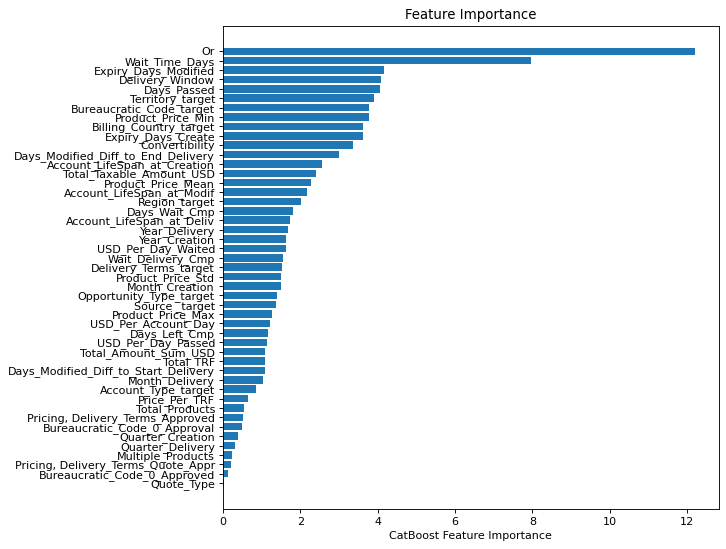

In [38]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

figure(num=None, figsize=(8, 8), dpi=80, facecolor='w', edgecolor='k')

sorted_idx = cat.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], cat.feature_importances_[sorted_idx])
plt.xlabel("CatBoost Feature Importance")
plt.title('Feature Importance')

In [39]:
train_set.loc[:, fts+['Opportunity_ID', 'Target']].to_csv('train_prepared.csv', index=False)
test_set.loc[:, fts+['Opportunity_ID']].to_csv('test_prepared.csv', index=False)